# STAT479 Final: Survival Analysis Deep Learning

Reference: https://nbviewer.org/github/havakv/pycox/blob/master/examples/01_introduction.ipynb

In [1]:
import pandas as pd

data = pd.read_csv("C:\\Users\\ntlmp\\STAT479-AppliedNeuralNetworksDeepLearning\\cirrhosis.csv")

This [dataset](https://archive.ics.uci.edu/dataset/878/cirrhosis+patient+survival+prediction+dataset-1) utilizes 17 clinical features for predicting survival states of patients with liver cirrhosis. The survival states include 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation).

### Dataset Features
- `ID` (int): unique identifer
- `Drug` (cat): type of drug D-penicillamine or placebo	
- `Age` (int): age
- `Sex` (cat): M (male) or F (female)
- `Ascites` (cat): presence of ascites N (No) or Y (Yes)
- `Hepatomegaly` (cat): presence of hepatomegaly N (No) or Y (Yes)
- `Spiders` (cat): presence of spiders N (No) or Y (Yes)
- `Edema` (cat): presence of edema N (no edema and no diuretic therapy for edema), S (edema present without diuretics, or edema resolved by diuretics), or Y (edema despite diuretic therapy)
- `Bilirubin` (num): serum bilirubin in [mg/dl]
- `Cholesterol` (int): serum cholesterol in [mg/dl]
- `Albumin` (num): albumin in [gm/dl]
- `Copper` (int): urine copper in [ug/day]
- `Alk_Phos` (num): alkaline phosphatase in [U/liter]
- `SGOT` (num): SGOT in [U/ml]
- `Tryglicerides` (int): triglicerides in [mg/dl]
- `Platelets` (int): platelets per cubic [ml/1000]
- `Prothrombin` (num): prothrombin time in seconds [s]
- `Stage` (cat): histologic stage of disease (1, 2, 3, or 4)

### Dataset Targets
- `N_Days` (int): number of days between registration and the earlier of death, transplantation, or sutdy analysis time
- `Status` (cat): status of the patient C (censored), CL (censored due to liver tx), or D (death)

In [2]:
data.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


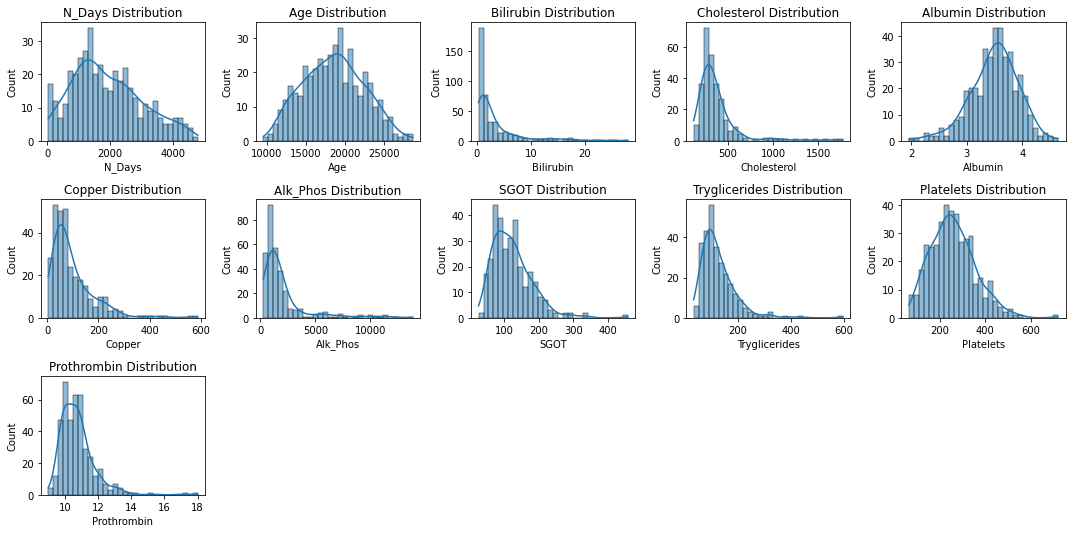

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_columns = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

# Set the size of the figure for better visibility
plt.figure(figsize=(15, 12))

# Loop through each numeric column and plot the distribution
for i, column in enumerate(numeric_columns):
    plt.subplot(5, 5, i+1)  # Adjust grid size to fit numeric columns
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f'{column} Distribution')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

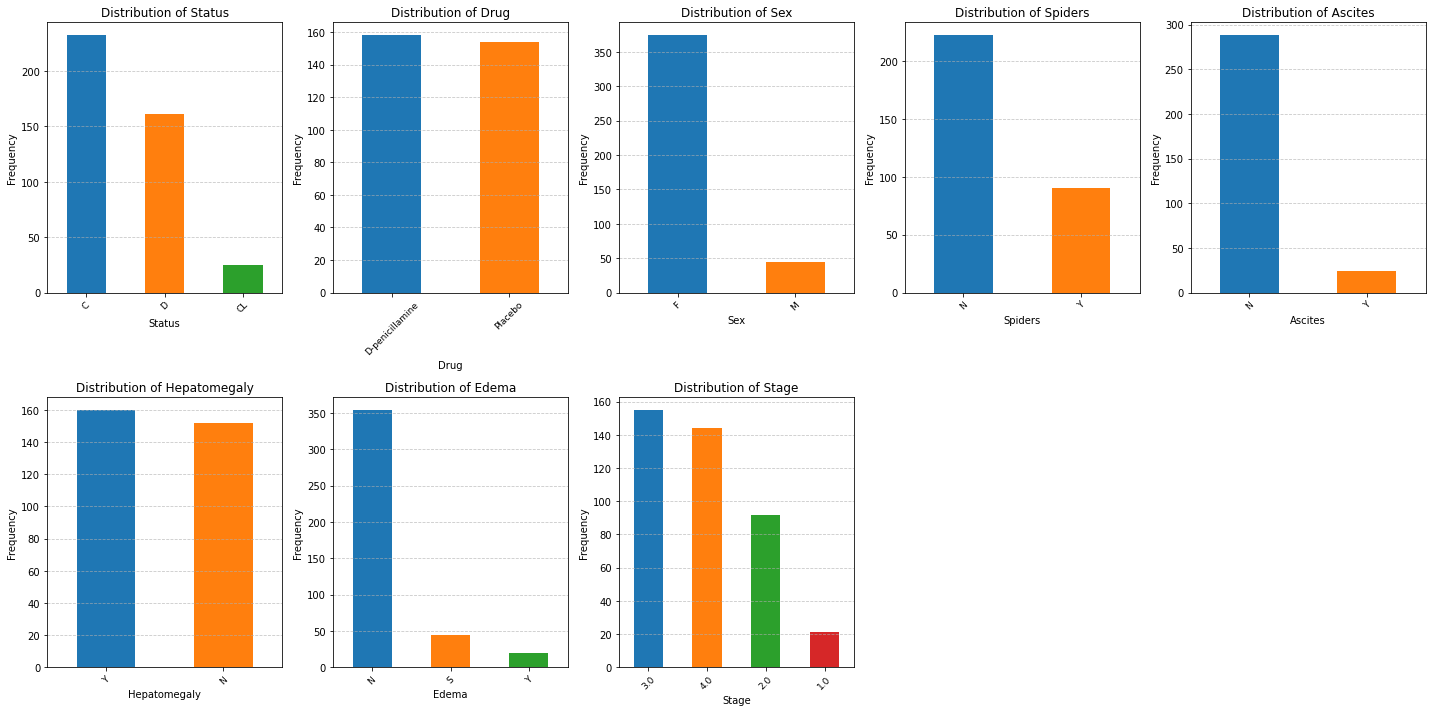

In [4]:
import matplotlib.pyplot as plt

categorical_columns = ['Status', 'Drug', 'Sex', 'Spiders', 'Ascites', 'Hepatomegaly', 'Edema', 'Stage']

# Calculate the number of rows needed based on the number of columns and charts per row
charts_per_row = 5
n_rows = (len(categorical_columns) + charts_per_row - 1) // charts_per_row

# Create a figure and a grid of subplots
fig, axes = plt.subplots(n_rows, charts_per_row, figsize=(20, 5 * n_rows))
fig.patch.set_facecolor('white')  # Set white background for the figure

# Flatten axes for easy indexing
axes = axes.flatten()

# Create bar charts for each categorical column
for idx, column in enumerate(categorical_columns):
    ax = axes[idx]
    data[column].value_counts().plot(
        kind='bar',
        color=plt.cm.tab10.colors,  # Use tab10 colormap for colors
        ax=ax
    )
    ax.set_title(f'Distribution of {column}', fontsize=12)
    ax.set_xlabel(column, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.tick_params(axis='x', labelrotation=45, labelsize=9)  # Rotate x-axis labels for better visibility
    ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines to the y-axis

# Hide unused subplots
for idx in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


## Data Preprocessing

Since a patient's baseline data may not be indicative on whether they were able to receive a transplant, we will be removing observations where patients received a liver transplant so we can best model the survival function.

In [ ]:
import numpy as np

# Replace 'CL' in the 'Status' column with NaN and drop missing rows
data['Status'] = data['Status'].replace('CL', np.nan)

In [6]:
# Check for duplicate rows
duplicates_count = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates_count}")

Number of duplicate rows: 0


In [7]:
# Check how many missing values are present
print(data.isnull().sum())

ID                 0
N_Days             0
Status            25
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64


In [8]:
data = data.dropna()
data.shape

(258, 20)

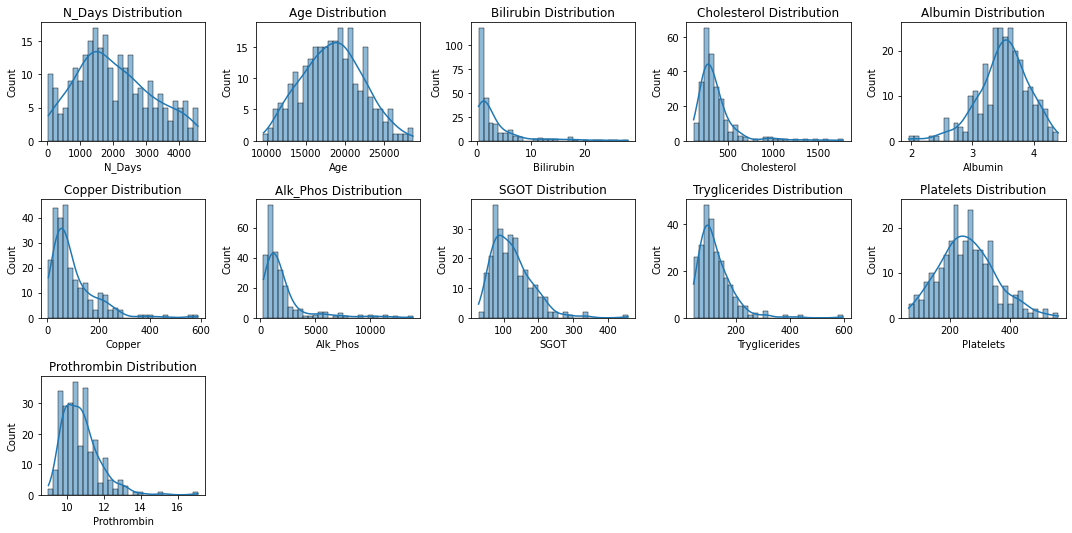

In [9]:
numeric_columns = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

# Set the size of the figure for better visibility
plt.figure(figsize=(15, 12))

# Loop through each numeric column and plot the distribution
for i, column in enumerate(numeric_columns):
    plt.subplot(5, 5, i+1)  # Adjust grid size to fit numeric columns
    sns.histplot(data[column], kde=True, bins=30)
    plt.title(f'{column} Distribution')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

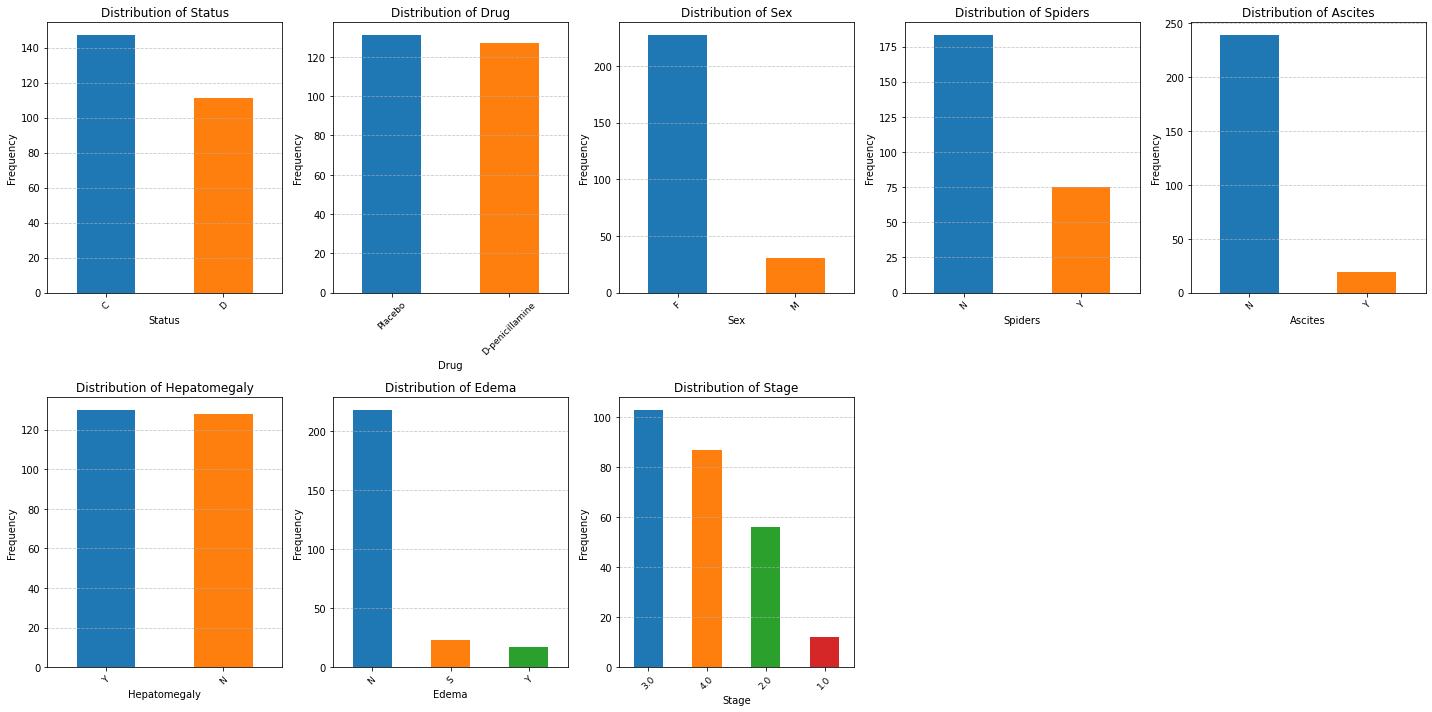

In [10]:
categorical_columns = ['Status', 'Drug', 'Sex', 'Spiders', 'Ascites', 'Hepatomegaly', 'Edema', 'Stage']

# Calculate the number of rows needed based on the number of columns and charts per row
charts_per_row = 5
n_rows = (len(categorical_columns) + charts_per_row - 1) // charts_per_row

# Create a figure and a grid of subplots
fig, axes = plt.subplots(n_rows, charts_per_row, figsize=(20, 5 * n_rows))
fig.patch.set_facecolor('white')  # Set white background for the figure

# Flatten axes for easy indexing
axes = axes.flatten()

# Create bar charts for each categorical column
for idx, column in enumerate(categorical_columns):
    ax = axes[idx]
    data[column].value_counts().plot(
        kind='bar',
        color=plt.cm.tab10.colors,  # Use tab10 colormap for colors
        ax=ax
    )
    ax.set_title(f'Distribution of {column}', fontsize=12)
    ax.set_xlabel(column, fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.tick_params(axis='x', labelrotation=45, labelsize=9)  # Rotate x-axis labels for better visibility
    ax.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines to the y-axis

# Hide unused subplots
for idx in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [11]:
# Convert 'Stage' to integer
data['Stage'] = data['Stage'].astype(int)
# Convert 'Stage' back to object
data['Stage'] = data['Stage'].astype(object)

In [12]:
data.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4
6,7,1832,C,Placebo,20284,F,N,Y,N,N,1.0,322.0,4.09,52.0,824.0,60.45,213.0,204.0,9.7,3


In [13]:
# Drop unique identifiers
df = data.drop(columns=['ID'])

# Perform one-hot encoding on categorical features
categorical_features = ['Drug', 'Sex', 'Spiders', 'Ascites', 'Hepatomegaly', 'Edema', 'Stage']
df = pd.get_dummies(df, columns=categorical_features, drop_first=True, dtype=int)

df.head()

,N_Days,Status,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,...,Drug_Placebo,Sex_M,Spiders_Y,Ascites_Y,Hepatomegaly_Y,Edema_S,Edema_Y,Stage_2,Stage_3,Stage_4
0,400,D,21464,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,...,0,0,1,1,1,0,1,0,0,1
1,4500,C,20617,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,...,0,0,1,0,1,0,0,0,1,0
2,1012,D,25594,1.4,176.0,3.48,210.0,516.0,96.10,55.0,...,0,1,0,0,0,1,0,0,0,1
3,1925,D,19994,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,...,0,0,1,0,1,1,0,0,0,1
6,1832,C,20284,1.0,322.0,4.09,52.0,824.0,60.45,213.0,...,1,0,0,0,1,0,0,0,1,0


In [ ]:
# df needs to be in `float32`

df['Status'] = df['Status'].map({'D': 0, 'C': 1})

# Convert all data to float32 for PyTorch compatibility
df = df.astype('float32')

In [15]:
df.head()

,N_Days,Status,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,...,Drug_Placebo,Sex_M,Spiders_Y,Ascites_Y,Hepatomegaly_Y,Edema_S,Edema_Y,Stage_2,Stage_3,Stage_4
0,400.0,0.0,21464.0,14.5,261.0,2.60,156.0,1718.000000,137.949997,172.0,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,4500.0,1.0,20617.0,1.1,302.0,4.14,54.0,7394.799805,113.519997,88.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1012.0,0.0,25594.0,1.4,176.0,3.48,210.0,516.000000,96.099998,55.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1925.0,0.0,19994.0,1.8,244.0,2.54,64.0,6121.799805,60.630001,92.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
6,1832.0,1.0,20284.0,1.0,322.0,4.09,52.0,824.000000,60.450001,213.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [16]:
# Start with the entire dataset
df_test = df.sample(frac=0.15, random_state=42)  # 10% for test set
df_train = df.drop(df_test.index)  # Remaining 90%

# Now split the remaining 90% into training and validation sets
df_val = df_train.sample(frac=0.15 / 0.85, random_state=42)  # 10% of the original = 0.1 / 0.9 of the remaining
df_train = df_train.drop(df_val.index)  # The rest is 80% for training

# Check the final proportions
print(f"Training set size: {df_train.shape[0]} ({df_train.shape[0] / df.shape[0]:.2%})")
print(f"Validation set size: {df_val.shape[0]} ({df_val.shape[0] / df.shape[0]:.2%})")
print(f"Test set size: {df_test.shape[0]} ({df_test.shape[0] / df.shape[0]:.2%})")


Training set size: 180 (69.77%)
Validation set size: 39 (15.12%)
Test set size: 39 (15.12%)


In [17]:
print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(180, 22)
(39, 22)
(39, 22)


In [18]:
# For preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

cols_standardize = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
cols_leave = ['Drug_Placebo', 'Sex_M', 'Spiders_Y', 'Ascites_Y', 'Hepatomegaly_Y', 'Edema_S', 'Edema_Y', 'Stage_2', 'Stage_3', 'Stage_4']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [19]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

## Model Design and Implementation

In [20]:
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['N_Days'].values, df['Status'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [21]:
import torch
import torchtuples as tt
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

# Define the PyTorch model
class Net(torch.nn.Module):
    def __init__(self, input_dim, output_dim, num_nodes, dropout):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, num_nodes[0])
        self.fc2 = torch.nn.Linear(num_nodes[0], num_nodes[1])
        self.fc3 = torch.nn.Linear(num_nodes[1], output_dim)
        self.relu = torch.nn.ReLU()
        self.batch_norm1 = torch.nn.BatchNorm1d(num_nodes[0])
        self.batch_norm2 = torch.nn.BatchNorm1d(num_nodes[1])
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.batch_norm1(x)
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.batch_norm2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Function to train and evaluate the model with given hyperparameters
def train_and_evaluate(x_train, y_train, x_val, y_val, input_dim, output_dim, num_nodes, dropout, lr, batch_size, epochs):
    net = Net(input_dim, output_dim, num_nodes, dropout)
    model = LogisticHazard(net, tt.optim.Adam(lr), duration_index=labtrans.cuts)
    callbacks = [tt.cb.EarlyStopping()]
    log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=(x_val, y_val))
    
    # Evaluate the model on validation data
    surv = model.predict_surv_df(x_val)
    ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
    c_index = ev.concordance_td('antolini')
    
    return c_index

# Hyperparameter configurations to try
hyperparams_list = [
    {'num_nodes': [32, 32], 'dropout': 0.1, 'lr': 0.01, 'batch_size': 256},
    {'num_nodes': [64, 64], 'dropout': 0.2, 'lr': 0.001, 'batch_size': 128},
    {'num_nodes': [64, 64], 'dropout': 0.2, 'lr': 0.0001, 'batch_size': 128},
    {'num_nodes': [128, 128], 'dropout': 0.3, 'lr': 0.0001, 'batch_size': 512},
]

# Train and evaluate the model with different hyperparameters
results = []
for hyperparams in hyperparams_list:
    c_index = train_and_evaluate(
        x_train=x_train,
        y_train=y_train,
        x_val=x_val,
        y_val=y_val,
        input_dim=x_train.shape[1],
        output_dim=labtrans.out_features,
        num_nodes=hyperparams['num_nodes'],
        dropout=hyperparams['dropout'],
        lr=hyperparams['lr'],
        batch_size=hyperparams['batch_size'],
        epochs=100
    )
    results.append({'hyperparams': hyperparams, 'c_index': c_index})

# Print the results
for result in results:
    print(f"Hyperparameters: {result['hyperparams']}, C-index: {result['c_index']}")

0:	[0s / 0s],		train_loss: 3.5399,	val_loss: 3.3818
1:	[0s / 0s],		train_loss: 3.3228,	val_loss: 3.3044
2:	[0s / 0s],		train_loss: 3.1575,	val_loss: 3.2366
3:	[0s / 0s],		train_loss: 3.0618,	val_loss: 3.1747
4:	[0s / 0s],		train_loss: 2.9305,	val_loss: 3.1127
5:	[0s / 0s],		train_loss: 2.8109,	val_loss: 3.0466
6:	[0s / 0s],		train_loss: 2.6780,	val_loss: 2.9773
7:	[0s / 0s],		train_loss: 2.6352,	val_loss: 2.8984
8:	[0s / 0s],		train_loss: 2.5038,	val_loss: 2.8105
9:	[0s / 0s],		train_loss: 2.4031,	val_loss: 2.7158
10:	[0s / 0s],		train_loss: 2.3375,	val_loss: 2.6176
11:	[0s / 0s],		train_loss: 2.2143,	val_loss: 2.5176
12:	[0s / 0s],		train_loss: 2.1781,	val_loss: 2.4174
13:	[0s / 0s],		train_loss: 2.0630,	val_loss: 2.3205
14:	[0s / 0s],		train_loss: 1.9548,	val_loss: 2.2257
15:	[0s / 0s],		train_loss: 1.8710,	val_loss: 2.1364
16:	[0s / 0s],		train_loss: 1.7858,	val_loss: 2.0533
17:	[0s / 0s],		train_loss: 1.6882,	val_loss: 1.9742
18:	[0s / 0s],		train_loss: 1.6315,	val_loss: 1.9016
19:

c:\Users\ntlmp\AppData\Local\r-miniconda\lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, *

0:	[0s / 0s],		train_loss: 3.4961,	val_loss: 3.3464
1:	[0s / 0s],		train_loss: 3.4196,	val_loss: 3.3110
2:	[0s / 0s],		train_loss: 3.5817,	val_loss: 3.2749
3:	[0s / 0s],		train_loss: 3.3711,	val_loss: 3.2421
4:	[0s / 0s],		train_loss: 3.2717,	val_loss: 3.2080
5:	[0s / 0s],		train_loss: 3.2158,	val_loss: 3.1728
6:	[0s / 0s],		train_loss: 3.1149,	val_loss: 3.1399
7:	[0s / 0s],		train_loss: 3.1473,	val_loss: 3.1051
8:	[0s / 0s],		train_loss: 3.1194,	val_loss: 3.0727
9:	[0s / 0s],		train_loss: 3.1248,	val_loss: 3.0409
10:	[0s / 0s],		train_loss: 3.0199,	val_loss: 3.0088
11:	[0s / 0s],		train_loss: 3.0667,	val_loss: 2.9771
12:	[0s / 0s],		train_loss: 2.9786,	val_loss: 2.9449
13:	[0s / 0s],		train_loss: 2.9825,	val_loss: 2.9157
14:	[0s / 0s],		train_loss: 3.0179,	val_loss: 2.8886
15:	[0s / 0s],		train_loss: 2.9054,	val_loss: 2.8614
16:	[0s / 0s],		train_loss: 2.7520,	val_loss: 2.8352
17:	[0s / 0s],		train_loss: 2.9275,	val_loss: 2.8142
18:	[0s / 0s],		train_loss: 2.6969,	val_loss: 2.7906
19:

c:\Users\ntlmp\AppData\Local\r-miniconda\lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, *

3:	[0s / 0s],		train_loss: 3.5790,	val_loss: 3.3501
4:	[0s / 0s],		train_loss: 3.5804,	val_loss: 3.3548
5:	[0s / 0s],		train_loss: 3.5448,	val_loss: 3.3657
6:	[0s / 0s],		train_loss: 3.6808,	val_loss: 3.3745
7:	[0s / 0s],		train_loss: 3.5265,	val_loss: 3.3826
8:	[0s / 0s],		train_loss: 3.5677,	val_loss: 3.3891
9:	[0s / 0s],		train_loss: 3.7144,	val_loss: 3.3933
10:	[0s / 0s],		train_loss: 3.5560,	val_loss: 3.4012
0:	[0s / 0s],		train_loss: 3.7534,	val_loss: 3.4122
1:	[0s / 0s],		train_loss: 3.7670,	val_loss: 3.4247
2:	[0s / 0s],		train_loss: 3.6983,	val_loss: 3.4366
3:	[0s / 0s],		train_loss: 3.7601,	val_loss: 3.4480
4:	[0s / 0s],		train_loss: 3.7469,	val_loss: 3.4605
5:	[0s / 0s],		train_loss: 3.7405,	val_loss: 3.4715
6:	[0s / 0s],		train_loss: 3.6870,	val_loss: 3.4820
7:	[0s / 0s],		train_loss: 3.7371,	val_loss: 3.4918
8:	[0s / 0s],		train_loss: 3.6991,	val_loss: 3.5015
9:	[0s / 0s],		train_loss: 3.7236,	val_loss: 3.5078
10:	[0s / 0s],		train_loss: 3.6296,	val_loss: 3.5154
Hyperparam

In [22]:
import torch  # For building the networks 
import torchtuples as tt  # Some useful functions

# Define model parameters
in_features = x_train.shape[1]
num_nodes = [64, 64]  # List of hidden layer sizes
out_features = labtrans.out_features
batch_norm = True
dropout = 0.3

# Dynamically construct the network
layers = []
input_dim = in_features

for nodes in num_nodes:
    # Add a linear layer
    layers.append(torch.nn.Linear(input_dim, nodes))
    # Add activation function
    layers.append(torch.nn.ReLU())
    # Add batch normalization if enabled
    if batch_norm:
        layers.append(torch.nn.BatchNorm1d(nodes))
    # Add dropout if specified
    if dropout > 0:
        layers.append(torch.nn.Dropout(dropout))
    # Update input dimension for the next layer
    input_dim = nodes

# Add the final output layer
layers.append(torch.nn.Linear(input_dim, out_features))

# Create the network
net = torch.nn.Sequential(*layers)


In [23]:
model = LogisticHazard(net, tt.optim.Adam(0.001), duration_index=labtrans.cuts)

In [24]:
batch_size = 512
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [25]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 3.8580,	val_loss: 3.5516
1:	[0s / 0s],		train_loss: 3.7572,	val_loss: 3.5430
2:	[0s / 0s],		train_loss: 3.7367,	val_loss: 3.5340
3:	[0s / 0s],		train_loss: 3.6504,	val_loss: 3.5232
4:	[0s / 0s],		train_loss: 3.7126,	val_loss: 3.5109
5:	[0s / 0s],		train_loss: 3.6461,	val_loss: 3.4966
6:	[0s / 0s],		train_loss: 3.6229,	val_loss: 3.4821
7:	[0s / 0s],		train_loss: 3.5567,	val_loss: 3.4656
8:	[0s / 0s],		train_loss: 3.4703,	val_loss: 3.4487
9:	[0s / 0s],		train_loss: 3.5152,	val_loss: 3.4305
10:	[0s / 0s],		train_loss: 3.4079,	val_loss: 3.4119
11:	[0s / 0s],		train_loss: 3.4520,	val_loss: 3.3922
12:	[0s / 0s],		train_loss: 3.3629,	val_loss: 3.3710
13:	[0s / 0s],		train_loss: 3.3709,	val_loss: 3.3488
14:	[0s / 0s],		train_loss: 3.3906,	val_loss: 3.3279
15:	[0s / 0s],		train_loss: 3.2899,	val_loss: 3.3083
16:	[0s / 0s],		train_loss: 3.2687,	val_loss: 3.2852
17:	[0s / 0s],		train_loss: 3.2396,	val_loss: 3.2631
18:	[0s / 0s],		train_loss: 3.1846,	val_loss: 3.2392
19:

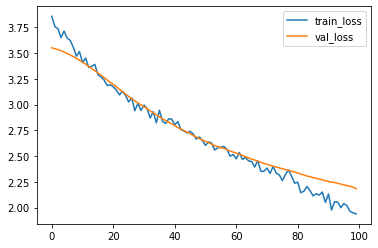

In [26]:
_ = log.plot()

## Prediction

In [27]:
surv = model.predict_surv_df(x_test)

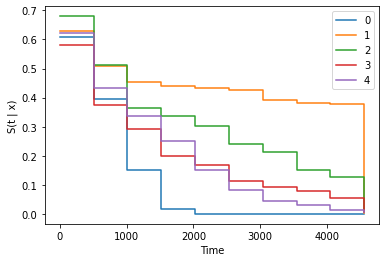

In [28]:
# let's plot the survival estimates for the first 5 individuals
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

It is often beneficial to interpolate the survival estimates. Linear interpolation (constant density interpolation) can be performed with the `interpolate` method. We also need to choose how many points we want to replace each grid point. Let's try 10.

In [29]:
surv = model.interpolate(10).predict_surv_df(x_test)

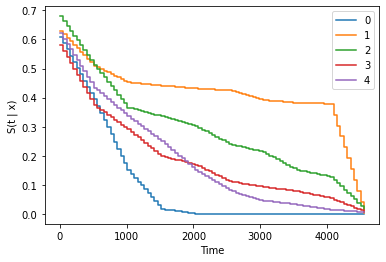

In [30]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

## Evaluation

The `EvalSurv` class contains some useful evaluation criteria for time-to-event prediction. We set ` censor_surv = 'km' ` to state that we want to use Kaplan-Meier for estimating the censoring distribution.

In [31]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

### Concordance

In [32]:
ev.concordance_td('antolini')

0.6221498371335505

## Results and Interpretation
The concordance index of 0.6221 is quite low. This could be attributed to factors like overfitting or hyperparameter tuning. This project was interesting to explore how different hyperparameters affect the concordance index, but none seem to generate a concorcordance index of above 0.7. It was also interesting to see how each of the dataset features attributed to the patient's status and time until event.